In [1]:
# Import data from Excel sheet
import pandas as pd
#df = pd.read_excel('/content/drive/My Drive/ADNI_komplett/ADNI combined.xlsx', sheet_name='sample')
df = pd.read_excel('ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV']
field = df['MRI_Field_Strength']
amybin = df['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI_demo/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI_demo/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI_demo/CN/*.nii.gz'))
#dataADNI3 = sorted(glob.glob('mwp1_MNI/ADNI3/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN #+ dataADNI3
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  45  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Actually load nifti files into array
import nibabel as nib
import numpy as np
from sklearn import linear_model
# 1. Dimension: Die Nummer des Samples
# 2. Dimension: Die Bildzeile
# 3. Dimension: Die Bildspalte
# 4. Dimension: Die Bildtiefe
# 5. Dimension: Die Farbkanäle
print('Loading files...')
# define FOV to reduce required memory size
x_range_from = 10; x_range_to = 110
y_range_from = 10; y_range_to = 130
z_range_from = 5; z_range_to = 105
images = np.zeros((numfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), dtype=np.float32) # numfiles× z × x × y ×1; avoid 64bit types
#print(images.shape)

for i in range(numfiles):   # for loop over files and load
  if (i % 50 == 0):
    print('Loading file %d of %d' % (i+1, numfiles))
  img = nib.load(dataFiles[i])
  img = img.get_fdata()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
  img = np.transpose(img, (2, 0, 1)) # reorder dimensions to match coronal view z*x*y in MRIcron etc.
  #img = np.fliplr(img) # flip upside down and
  #img = np.flipud(img) # left/right to match MRIcroN views when plotted directly
  #img = np.flip(img, 2) # flip front/back
  img = np.flip(img) # flip all positions
  #print(img.shape)
  images[i, :,:,:, 0] = np.nan_to_num(img)
print('Successfully loaded files')
print('Image array size: ', images.shape)

Loading files...
Loading file 1 of 45
Successfully loaded files
Image array size:  (45, 100, 100, 120, 1)


In [5]:
# save original images array to disk
import h5py
hf = h5py.File('orig_images_demo.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
hf.close()
#!ls -lh /content/drive/My\ Drive/ADNI_komplett

In [6]:
# Display a single scan
from matplotlib import pyplot as plt
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) and then normalising to 0 mean and 1 std
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each fifth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')

displaying image  mwp1_MNI_demo/AD\mwp1AD_4001_037_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310.nii.gz


In [7]:
# Perform regression-based covariates cleaning
from sklearn import linear_model
from pandas import DataFrame

covariates = DataFrame({'Age':age, 'Sex':sex, 'TIV':tiv, 'FieldStrength':field}).iloc[cov_idx, :]
print("Covariates data frame size : ", covariates.shape)
print(covariates.head())
#print(label.head())
covariates = covariates.to_numpy(dtype=np.float32) # convert dataframe to nparray with 32bit types

#load coefficients for linear models from hdf5
hf = h5py.File('linearmodels.hdf5', 'r')
hf.keys # read keys
lmarray = np.array(hf.get('linearmodels'), dtype=np.float32) #stores 4 coefficients + 1 intercept per voxel
hf.close() 

covCN = covariates[labels['Group'] == 0] # only controls as reference group to estimate effect of covariates
print("Controls covariates data frame size : ", covCN.shape)
lmLoaded = linear_model.LinearRegression()


for k in range(images.shape[3]):
  print('Processing depth slice ', str(k+1), ' of ', str(images.shape[3]))
  for j in range(images.shape[2]):
    for i in range(images.shape[1]):
        
      if any(lmarray[k,j,i,:] != 0):
        tmpdat = images[labels['Group'] == 0, i, j, k, 0]
        
        #load fitted linear model from file
        lmLoaded.coef_ = lmarray[k,j,i, :4]
        lmLoaded.intercept_ = lmarray[k,j,i,4]
        
        pred = lmLoaded.predict(covariates) # calculate prediction for all subjects
        images[:, i, j, k, 0] = images[:, i, j, k, 0] - pred # % subtract effect of covariates from original values (=calculate residuals)


Covariates data frame size :  (45, 4)
      Age  Sex      TIV  FieldStrength
130  89.0    1  1203.87            3.0
135  90.0    0  1302.61            3.0
144  56.0    1  1276.72            3.0
154  56.0    0  1387.65            3.0
181  74.0    0  1491.23            1.5
Controls covariates data frame size :  (15, 4)
Processing depth slice  1  of  120
Processing depth slice  2  of  120
Processing depth slice  3  of  120
Processing depth slice  4  of  120
Processing depth slice  5  of  120
Processing depth slice  6  of  120
Processing depth slice  7  of  120
Processing depth slice  8  of  120
Processing depth slice  9  of  120
Processing depth slice  10  of  120
Processing depth slice  11  of  120
Processing depth slice  12  of  120
Processing depth slice  13  of  120
Processing depth slice  14  of  120
Processing depth slice  15  of  120
Processing depth slice  16  of  120
Processing depth slice  17  of  120
Processing depth slice  18  of  120
Processing depth slice  19  of  120
Proces

In [8]:
# assert False # uncomment to really override existing file on drive
# Save residualized data to disk
import h5py
hf = h5py.File('residuals_demo.hdf5', 'w')
hf.create_dataset('labels', data=labels, compression='gzip')
hf.create_dataset('images', data=images, compression='gzip')
# don't store Strings or String arrays in HDF5 containers as this is problematic
hf.close()

In [10]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_demo.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels))
print(images.shape)

(45, 100, 100, 120, 1)


displaying residual image  mwp1_MNI_demo/AD\mwp1AD_4001_037_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310.nii.gz


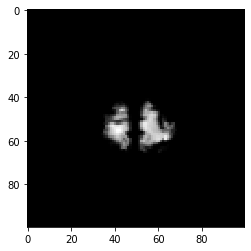

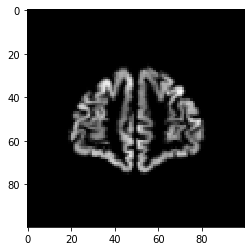

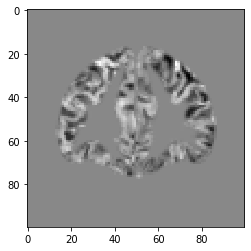

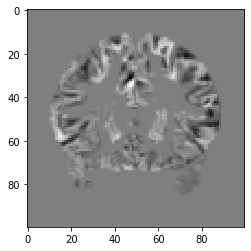

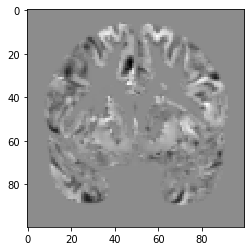

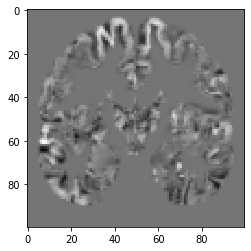

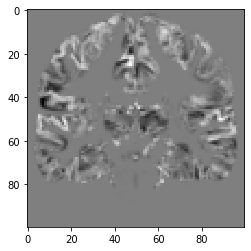

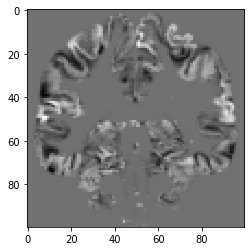

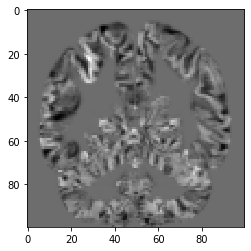

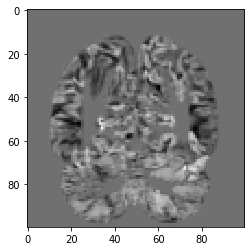

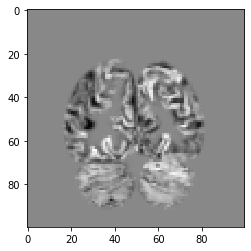

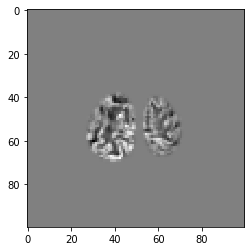

In [11]:
# Display a single scan (residuals)
from matplotlib import pyplot as plt
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) and then normalising to 0 mean and 1 std
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying residual image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each fifth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')